In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.reset_index()
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn
Start knn
Num of unique id: 569408
Num of train data: 11388160
Pos rate: 0.08787117497471057
           index                id          match_id     kdist  kneighbors  \
3758063   683961  E_99a140a34f285e  E_c6d67cce880b89  0.004885           6   
4129113   286764  E_405f9c2c763e2a  E_3ff9414bca6b59  0.001146           7   
4251869   532418  E_77a7261e5e52fa  E_e9f5c8e7e65b69  0.003156           7   
10838572   39651  E_08e1f8e863777c  E_897b6d8bf8b758  0.009152          19   
348480    697719  E_9cb61b103c9671  E_9cb61b103c9671  0.000000           0   

          label  
3758063       0  
4129113       0  
4251869       0  
10838572      0  
348480        1  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9202998613655506


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,91.21%,8.79%
development set - fold 0,91.21%,8.79%
validation set - fold 0,91.21%,8.79%
development set - fold 1,91.21%,8.79%
validation set - fold 1,91.21%,8.79%
development set - fold 2,91.21%,8.79%
validation set - fold 2,91.21%,8.79%
development set - fold 3,91.21%,8.79%
validation set - fold 3,91.21%,8.79%
development set - fold 4,91.21%,8.79%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

62
['kdist', 'kneighbors', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'categories_CE_2']


In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0500899
[100]	valid_0's binary_logloss: 0.0472248
[150]	valid_0's binary_logloss: 0.0459493
[200]	valid_0's binary_logloss: 0.0450043
[250]	valid_0's binary_logloss: 0.0443908
[300]	valid_0's binary_logloss: 0.0439164
[350]	valid_0's binary_logloss: 0.0434102
[400]	valid_0's binary_logloss: 0.0429787
[450]	valid_0's binary_logloss: 0.0426591
[500]	valid_0's binary_logloss: 0.0423099
[550]	valid_0's binary_logloss: 0.0420533
[600]	valid_0's binary_logloss: 0.0417987
[650]	valid_0's binary_logloss: 0.0415369
[700]	valid_0's binary_logloss: 0.0412407
[750]	valid_0's binary_logloss: 0.041017
[800]	valid_0's binary_logloss: 0.0408101
[850]	valid_0's binary_logloss: 0.0406173
[900]	valid_0's binary_logloss: 0.0404615
[950]	valid_0's binary_logloss: 0.0402929
[1000]	valid_0's binary_logloss: 0.040128
[1050]	valid_0's binary_logloss: 0.039986
[1100]	valid_0's binary_logloss: 0.0398699
[1150]	valid_0's binary_logloss: 0.0397199
[1200]	valid_0's binary_logloss: 0

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

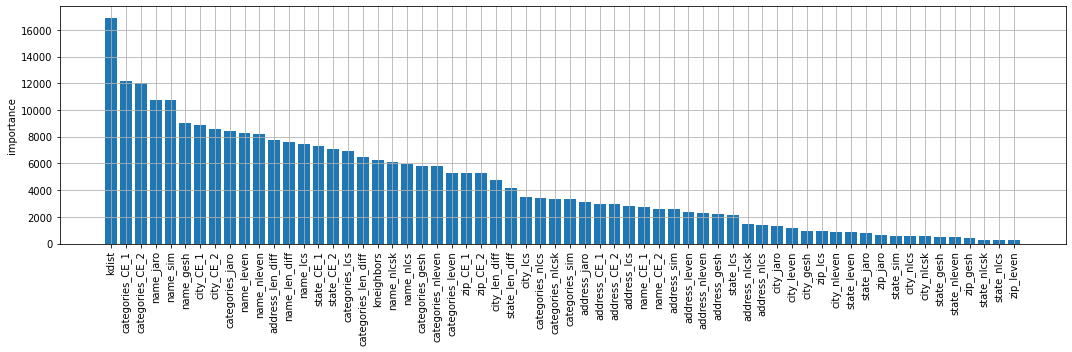

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-02 05:51:40,300] A new study created in memory with name: no-name-95060b41-11b0-44dd-91b5-1c7d59003828
[I 2022-06-02 05:52:06,317] Trial 0 finished with value: 0.8165655754800571 and parameters: {'threshold': 0.887285463439302}. Best is trial 0 with value: 0.8165655754800571.


CV: 0.816566


[I 2022-06-02 05:52:23,135] Trial 1 finished with value: 0.6952471909470158 and parameters: {'threshold': 0.9990510824604507}. Best is trial 0 with value: 0.8165655754800571.


CV: 0.695247


[I 2022-06-02 05:52:42,190] Trial 2 finished with value: 0.8225965195315761 and parameters: {'threshold': 0.8482264624662945}. Best is trial 2 with value: 0.8225965195315761.


CV: 0.822597


[I 2022-06-02 05:53:01,322] Trial 3 finished with value: 0.8283515318846538 and parameters: {'threshold': 0.3673097312251018}. Best is trial 3 with value: 0.8283515318846538.


CV: 0.828352


[I 2022-06-02 05:53:20,586] Trial 4 finished with value: 0.8318015273216295 and parameters: {'threshold': 0.7313379124214757}. Best is trial 4 with value: 0.8318015273216295.


CV: 0.831802


[I 2022-06-02 05:53:39,600] Trial 5 finished with value: 0.8222608903425817 and parameters: {'threshold': 0.8508204845857005}. Best is trial 4 with value: 0.8318015273216295.


CV: 0.822261


[I 2022-06-02 05:53:58,187] Trial 6 finished with value: 0.8338419545916551 and parameters: {'threshold': 0.5097900423949518}. Best is trial 6 with value: 0.8338419545916551.


CV: 0.833842


[I 2022-06-02 05:54:16,783] Trial 7 finished with value: 0.7910717065746493 and parameters: {'threshold': 0.9599224006194528}. Best is trial 6 with value: 0.8338419545916551.


CV: 0.791072


[I 2022-06-02 05:54:35,615] Trial 8 finished with value: 0.8119913509375815 and parameters: {'threshold': 0.9083729853751309}. Best is trial 6 with value: 0.8338419545916551.


CV: 0.811991


[I 2022-06-02 05:54:55,366] Trial 9 finished with value: 0.7839731882213105 and parameters: {'threshold': 0.10213591818067946}. Best is trial 6 with value: 0.8338419545916551.


CV: 0.783973


[I 2022-06-02 05:55:14,840] Trial 10 finished with value: 0.8342107074881087 and parameters: {'threshold': 0.530070853973087}. Best is trial 10 with value: 0.8342107074881087.


CV: 0.834211


[I 2022-06-02 05:55:34,293] Trial 11 finished with value: 0.8342598742714269 and parameters: {'threshold': 0.5352024257161163}. Best is trial 11 with value: 0.8342598742714269.


CV: 0.834260


[I 2022-06-02 05:55:53,791] Trial 12 finished with value: 0.8344304012911335 and parameters: {'threshold': 0.5494078338572241}. Best is trial 12 with value: 0.8344304012911335.


CV: 0.834430


[I 2022-06-02 05:56:12,546] Trial 13 finished with value: 0.8283166641060538 and parameters: {'threshold': 0.36646188508120914}. Best is trial 12 with value: 0.8344304012911335.


CV: 0.828317


[I 2022-06-02 05:56:31,902] Trial 14 finished with value: 0.8336051531295955 and parameters: {'threshold': 0.6679143765872286}. Best is trial 12 with value: 0.8344304012911335.


CV: 0.833605


[I 2022-06-02 05:56:51,680] Trial 15 finished with value: 0.8267470649006909 and parameters: {'threshold': 0.34097418828948944}. Best is trial 12 with value: 0.8344304012911335.


CV: 0.826747


[I 2022-06-02 05:57:11,138] Trial 16 finished with value: 0.8344550387003801 and parameters: {'threshold': 0.6117134804414794}. Best is trial 16 with value: 0.8344550387003801.


CV: 0.834455


[I 2022-06-02 05:57:29,408] Trial 17 finished with value: 0.8334572773809905 and parameters: {'threshold': 0.6747453393565778}. Best is trial 16 with value: 0.8344550387003801.


CV: 0.833457


[I 2022-06-02 05:57:49,832] Trial 18 finished with value: 0.810843986089582 and parameters: {'threshold': 0.19878791434651422}. Best is trial 16 with value: 0.8344550387003801.


CV: 0.810844


[I 2022-06-02 05:58:09,114] Trial 19 finished with value: 0.8344430654699655 and parameters: {'threshold': 0.6110125479619859}. Best is trial 16 with value: 0.8344550387003801.


CV: 0.834443


[I 2022-06-02 05:58:28,211] Trial 20 finished with value: 0.8297221252940032 and parameters: {'threshold': 0.7682492856613703}. Best is trial 16 with value: 0.8344550387003801.


CV: 0.829722


[I 2022-06-02 05:58:46,584] Trial 21 finished with value: 0.8345199608880716 and parameters: {'threshold': 0.6051325037189801}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.834520


[I 2022-06-02 05:59:05,829] Trial 22 finished with value: 0.8345099397344128 and parameters: {'threshold': 0.6079941069846394}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.834510


[I 2022-06-02 05:59:25,485] Trial 23 finished with value: 0.8313460063808503 and parameters: {'threshold': 0.4258817880900952}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.831346


[I 2022-06-02 05:59:44,833] Trial 24 finished with value: 0.8344667535328186 and parameters: {'threshold': 0.617715423362237}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.834467


[I 2022-06-02 06:00:03,096] Trial 25 finished with value: 0.8294855217646038 and parameters: {'threshold': 0.7718836670292561}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.829486


[I 2022-06-02 06:00:22,719] Trial 26 finished with value: 0.8318773515378048 and parameters: {'threshold': 0.43859598696022895}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.831877


[I 2022-06-02 06:00:42,596] Trial 27 finished with value: 0.8202769795883027 and parameters: {'threshold': 0.2668455702281224}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.820277


[I 2022-06-02 06:01:02,011] Trial 28 finished with value: 0.8345023320068986 and parameters: {'threshold': 0.6071192248269381}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.834502


[I 2022-06-02 06:01:20,712] Trial 29 finished with value: 0.8326643837461892 and parameters: {'threshold': 0.7051494442020688}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.832664


[I 2022-06-02 06:01:40,250] Trial 30 finished with value: 0.8325542323813268 and parameters: {'threshold': 0.45507806880913143}. Best is trial 21 with value: 0.8345199608880716.


CV: 0.832554


[I 2022-06-02 06:01:59,597] Trial 31 finished with value: 0.8345560279814391 and parameters: {'threshold': 0.5914755803903425}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834556


[I 2022-06-02 06:02:19,060] Trial 32 finished with value: 0.8345539439610534 and parameters: {'threshold': 0.5966874319588014}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834554


[I 2022-06-02 06:02:37,148] Trial 33 finished with value: 0.8271086944224628 and parameters: {'threshold': 0.8061945688530997}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.827109


[I 2022-06-02 06:02:56,366] Trial 34 finished with value: 0.8336834632650505 and parameters: {'threshold': 0.6658576240600217}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833683


[I 2022-06-02 06:03:15,903] Trial 35 finished with value: 0.8330871101851043 and parameters: {'threshold': 0.4742366829141551}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833087


[I 2022-06-02 06:03:35,348] Trial 36 finished with value: 0.8345482153066416 and parameters: {'threshold': 0.558617081329713}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834548


[I 2022-06-02 06:03:54,802] Trial 37 finished with value: 0.8344762777378549 and parameters: {'threshold': 0.5531912000630496}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834476


[I 2022-06-02 06:04:13,044] Trial 38 finished with value: 0.8315567151801665 and parameters: {'threshold': 0.7359850034931068}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.831557


[I 2022-06-02 06:04:32,810] Trial 39 finished with value: 0.8307059963292088 and parameters: {'threshold': 0.4119556186706798}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.830706


[I 2022-06-02 06:04:52,700] Trial 40 finished with value: 0.8226906587597771 and parameters: {'threshold': 0.29079446009704935}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.822691


[I 2022-06-02 06:05:11,110] Trial 41 finished with value: 0.834526001532948 and parameters: {'threshold': 0.5806038086122576}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834526


[I 2022-06-02 06:05:30,776] Trial 42 finished with value: 0.8345523801864726 and parameters: {'threshold': 0.5697317086606796}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834552


[I 2022-06-02 06:05:50,256] Trial 43 finished with value: 0.8336808478241051 and parameters: {'threshold': 0.5028344400707628}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833681


[I 2022-06-02 06:06:08,741] Trial 44 finished with value: 0.834555888070644 and parameters: {'threshold': 0.558251578434756}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834556


[I 2022-06-02 06:06:28,282] Trial 45 finished with value: 0.833553098412389 and parameters: {'threshold': 0.49291713358791706}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833553


[I 2022-06-02 06:06:51,432] Trial 46 finished with value: 0.6516462282055714 and parameters: {'threshold': 0.011967254603953703}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.651646


[I 2022-06-02 06:07:10,736] Trial 47 finished with value: 0.8335423613215073 and parameters: {'threshold': 0.670720555072811}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833542


[I 2022-06-02 06:07:30,201] Trial 48 finished with value: 0.8345118727088832 and parameters: {'threshold': 0.5552457986058044}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834512


[I 2022-06-02 06:07:48,860] Trial 49 finished with value: 0.8288419866319546 and parameters: {'threshold': 0.37533403572318935}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.828842


[I 2022-06-02 06:08:08,388] Trial 50 finished with value: 0.8337298455880437 and parameters: {'threshold': 0.5065159507167787}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833730


[I 2022-06-02 06:08:27,837] Trial 51 finished with value: 0.8345442051674761 and parameters: {'threshold': 0.5613443026249636}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.834544


[I 2022-06-02 06:08:46,044] Trial 52 finished with value: 0.833847314574127 and parameters: {'threshold': 0.6541484056848228}. Best is trial 31 with value: 0.8345560279814391.


CV: 0.833847


[I 2022-06-02 06:09:05,380] Trial 53 finished with value: 0.8345822124008468 and parameters: {'threshold': 0.5639626284788222}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834582


[I 2022-06-02 06:09:24,579] Trial 54 finished with value: 0.8324234268321877 and parameters: {'threshold': 0.7127432884651244}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.832423


[I 2022-06-02 06:09:44,319] Trial 55 finished with value: 0.8340078689918038 and parameters: {'threshold': 0.5202387404862777}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834008


[I 2022-06-02 06:10:02,788] Trial 56 finished with value: 0.8345248079200756 and parameters: {'threshold': 0.5791626546077397}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834525


[I 2022-06-02 06:10:22,361] Trial 57 finished with value: 0.8329156037655159 and parameters: {'threshold': 0.46842032919953935}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.832916


[I 2022-06-02 06:10:40,633] Trial 58 finished with value: 0.8341839603925265 and parameters: {'threshold': 0.6381153891557212}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834184


[I 2022-06-02 06:10:59,709] Trial 59 finished with value: 0.8327399399052816 and parameters: {'threshold': 0.7011460048586614}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.832740


[I 2022-06-02 06:11:19,400] Trial 60 finished with value: 0.8304898203133765 and parameters: {'threshold': 0.40655164984207615}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.830490


[I 2022-06-02 06:11:37,716] Trial 61 finished with value: 0.8344727636381931 and parameters: {'threshold': 0.5534902419270146}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834473


[I 2022-06-02 06:11:57,054] Trial 62 finished with value: 0.8345573341375931 and parameters: {'threshold': 0.5664959967364551}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834557


[I 2022-06-02 06:12:16,375] Trial 63 finished with value: 0.8340967321329333 and parameters: {'threshold': 0.6421104157547572}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834097


[I 2022-06-02 06:12:34,840] Trial 64 finished with value: 0.8345359710878021 and parameters: {'threshold': 0.58978412491455}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834536


[I 2022-06-02 06:12:54,263] Trial 65 finished with value: 0.8339572566689994 and parameters: {'threshold': 0.5187001298731386}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833957


[I 2022-06-02 06:13:13,446] Trial 66 finished with value: 0.8342959742164882 and parameters: {'threshold': 0.6323198109807634}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834296


[I 2022-06-02 06:13:33,083] Trial 67 finished with value: 0.8332527037259431 and parameters: {'threshold': 0.4800472601182896}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833253


[I 2022-06-02 06:13:51,186] Trial 68 finished with value: 0.8307267127768145 and parameters: {'threshold': 0.7516870735473087}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.830727


[I 2022-06-02 06:14:10,557] Trial 69 finished with value: 0.8342738898329228 and parameters: {'threshold': 0.5359130176747184}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834274


[I 2022-06-02 06:14:29,311] Trial 70 finished with value: 0.8156315422215408 and parameters: {'threshold': 0.8920757527584574}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.815632


[I 2022-06-02 06:14:48,701] Trial 71 finished with value: 0.8345308870470444 and parameters: {'threshold': 0.5713131917151804}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834531


[I 2022-06-02 06:15:07,119] Trial 72 finished with value: 0.834527991240891 and parameters: {'threshold': 0.5880656034559089}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834528


[I 2022-06-02 06:15:26,516] Trial 73 finished with value: 0.834288350303702 and parameters: {'threshold': 0.5362377188093864}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834288


[I 2022-06-02 06:15:45,767] Trial 74 finished with value: 0.834284533748703 and parameters: {'threshold': 0.6329783916801169}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834285


[I 2022-06-02 06:16:04,428] Trial 75 finished with value: 0.8321115219767706 and parameters: {'threshold': 0.4447171758408054}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.832112


[I 2022-06-02 06:16:23,787] Trial 76 finished with value: 0.8345252858433444 and parameters: {'threshold': 0.6017911382356546}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834525


[I 2022-06-02 06:16:42,159] Trial 77 finished with value: 0.7802082998180982 and parameters: {'threshold': 0.9726669503473233}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.780208


[I 2022-06-02 06:17:01,447] Trial 78 finished with value: 0.8332245017981648 and parameters: {'threshold': 0.6844168686954339}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833225


[I 2022-06-02 06:17:20,935] Trial 79 finished with value: 0.8344567699198425 and parameters: {'threshold': 0.5502407387037926}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834457


[I 2022-06-02 06:17:39,477] Trial 80 finished with value: 0.8335495425148745 and parameters: {'threshold': 0.4925111419935919}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833550


[I 2022-06-02 06:17:58,862] Trial 81 finished with value: 0.8345267765397291 and parameters: {'threshold': 0.5792943585810875}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834527


[I 2022-06-02 06:18:18,252] Trial 82 finished with value: 0.8345157825505555 and parameters: {'threshold': 0.6147612467334248}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834516


[I 2022-06-02 06:18:36,698] Trial 83 finished with value: 0.8345291147006576 and parameters: {'threshold': 0.5785762124505176}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834529


[I 2022-06-02 06:18:56,102] Trial 84 finished with value: 0.8341288403781422 and parameters: {'threshold': 0.524980304214413}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834129


[I 2022-06-02 06:19:15,536] Trial 85 finished with value: 0.8345381172228957 and parameters: {'threshold': 0.5627242772628449}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834538


[I 2022-06-02 06:19:34,106] Trial 86 finished with value: 0.8345434843523102 and parameters: {'threshold': 0.5591390620181891}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834543


[I 2022-06-02 06:19:53,316] Trial 87 finished with value: 0.8338693113357074 and parameters: {'threshold': 0.6537316760289087}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833869


[I 2022-06-02 06:20:13,013] Trial 88 finished with value: 0.8327572776198551 and parameters: {'threshold': 0.46254228342725556}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.832757


[I 2022-06-02 06:20:31,237] Trial 89 finished with value: 0.8344196998525601 and parameters: {'threshold': 0.6201742440073541}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834420


[I 2022-06-02 06:20:50,428] Trial 90 finished with value: 0.8330916511384413 and parameters: {'threshold': 0.6886619017853881}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833092


[I 2022-06-02 06:21:09,746] Trial 91 finished with value: 0.8344673532940036 and parameters: {'threshold': 0.5520380356319168}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834467


[I 2022-06-02 06:21:29,138] Trial 92 finished with value: 0.8345146446644244 and parameters: {'threshold': 0.5552890639576251}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834515


[I 2022-06-02 06:21:48,634] Trial 93 finished with value: 0.8336482855163201 and parameters: {'threshold': 0.5013979412129331}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833648


[I 2022-06-02 06:22:07,208] Trial 94 finished with value: 0.8345438717536995 and parameters: {'threshold': 0.5694547858974234}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834544


[I 2022-06-02 06:22:26,446] Trial 95 finished with value: 0.8345642712497666 and parameters: {'threshold': 0.5964757761344526}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834564


[I 2022-06-02 06:22:45,675] Trial 96 finished with value: 0.8345557194778437 and parameters: {'threshold': 0.5961679704154785}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834556


[I 2022-06-02 06:23:03,960] Trial 97 finished with value: 0.8345289831929122 and parameters: {'threshold': 0.6031392262169316}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.834529


[I 2022-06-02 06:23:23,074] Trial 98 finished with value: 0.8337948569094809 and parameters: {'threshold': 0.6574162961758254}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833795


[I 2022-06-02 06:23:42,439] Trial 99 finished with value: 0.8339988033612611 and parameters: {'threshold': 0.5200174683726168}. Best is trial 53 with value: 0.8345822124008468.


CV: 0.833999


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5639626284788222

In [ ]:
study.best_value

0.8345822124008468

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.834582


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.358390e+05,135839.000000,135839.000000,135839.0,135839.000000,135839.000000,135839.000000,135839.000000,135839.000000,135839.000000,...,101908.000000,101908.000000,101908.000000,115694.000000,116196.000000,135839.000000,101908.000000,101908.000000,101908.000000,1.358390e+05
mean,5.704782e+05,0.007891,6.294061,1.0,0.262020,0.404821,16.708007,0.571189,8.450438,0.000028,...,12.447776,0.674120,8.914119,0.004897,0.004862,9.045848,0.538514,0.578882,0.581443,1.844631e-01
std,3.291375e+05,0.071397,5.254262,0.0,0.297326,0.247940,9.434542,0.226265,6.377583,0.000283,...,11.525406,0.242862,7.190790,0.005908,0.005880,10.911218,0.352432,0.329251,0.329448,1.752039e-01
min,7.000000e+00,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,4.673805e-10
25%,2.864000e+05,0.000450,2.000000,1.0,0.000000,0.205128,10.000000,0.447619,4.000000,0.000002,...,0.000000,0.483041,4.000000,0.000715,0.000706,0.000000,0.000000,0.285714,0.285714,2.449011e-02
50%,5.677360e+05,0.001116,5.000000,1.0,0.164300,0.387097,16.000000,0.561610,7.000000,0.000002,...,12.000000,0.584046,7.000000,0.002529,0.002503,6.000000,0.714286,0.470588,0.473684,1.262738e-01
75%,8.570690e+05,0.003052,10.000000,1.0,0.488334,0.582278,22.000000,0.698413,12.000000,0.000002,...,17.000000,1.000000,12.000000,0.006027,0.005943,13.000000,0.823529,1.000000,1.000000,3.238607e-01
max,1.138810e+06,4.448372,19.000000,1.0,1.000000,1.000000,59.000000,1.000000,53.000000,0.004961,...,87.000000,1.000000,77.000000,0.022032,0.022032,91.000000,1.000000,1.000000,1.000000,5.639623e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
2790209,1024916,E_e648e7aed48edd,E_82734c8e1c10d6,0.003437,4,1,0.070263,0.291667,43.0,0.528101,...,12.0,0.478571,3.0,0.006869,0.000604,4,0.857143,0.214286,0.300000,0.000061
1074906,1010804,E_e3113b1f3f918d,E_7db4c43deb6c08,0.000337,1,1,0.000000,0.285714,34.0,0.559981,...,0.0,1.000000,19.0,0.000829,0.000829,0,0.000000,1.000000,1.000000,0.327656
1976735,536647,E_7898405513ace1,E_fb6290eb6d5c5d,0.000494,3,1,0.307100,0.464286,26.0,0.584644,...,NaN,NaN,NaN,NaN,0.003430,9,NaN,NaN,NaN,0.274359
5068579,1026372,E_e69cb833ca9396,E_9de6b67fa4710c,0.000437,8,1,0.000000,0.000000,22.0,0.000000,...,21.0,0.539960,5.0,0.000688,0.004355,15,0.807692,0.192308,0.454545,0.334796
778696,418386,E_5dfe0057fe3fac,E_af38084bf295ba,0.038953,1,1,0.000000,0.000000,14.0,0.000000,...,NaN,NaN,NaN,NaN,0.000915,6,NaN,NaN,NaN,0.001289
1015389,891699,E_c84eec4d5c1378,E_fc9d593151bdc4,0.000261,1,1,0.000000,0.200000,6.0,0.492063,...,0.0,1.000000,19.0,0.000292,0.000292,0,0.000000,1.000000,1.000000,0.323912
1224847,172001,E_2691fae53ad808,E_057a9238e67ac3,0.000688,2,1,0.396663,0.790698,9.0,0.835080,...,14.0,0.341667,2.0,0.002792,0.018813,11,0.875000,0.400000,0.125000,0.015259
2850373,6720,E_0184dd91b7fbdd,E_79a1ef57468b10,0.001172,5,1,0.000000,0.666667,7.0,0.867492,...,NaN,NaN,NaN,NaN,0.008548,6,NaN,NaN,NaN,0.161440
2857770,21472,E_04d37344e3b493,E_a0b65b50fe2d13,0.000404,5,1,0.000000,0.140351,28.0,0.547908,...,NaN,NaN,NaN,0.000028,NaN,34,NaN,NaN,NaN,0.052700
1814374,212093,E_2f9f5a5d1759c5,E_518adf9470b87c,0.002488,3,1,0.000000,0.160000,23.0,0.612027,...,30.0,0.414286,5.0,0.000309,0.000002,25,0.857143,0.142857,0.500000,0.006485


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
594655,E_85a798e1e07c52,Pathumwan Princess Hotel (โรงแรมปทุมวันปริ๊นเซส),13.743255,100.529905,444 Phaya Thai Rd,Pathum Wan,Bangkok,10330,TH,http://www.pprincess.com,22163700,Hotels,P_26b49f2cefaa63,2,1.0
976784,E_db6de9537688e1,Pratumwan Princess's Palace,13.743518,100.530290,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_26b49f2cefaa63,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
431604,E_61015f39c55f49,NOVOTEL HOTEL NU AING!!!!!,-6.90491,107.604357,Jl Cihampelas 23-25,Bandung,jabar,40000,ID,NaN,NaN,Hotels,P_82252ce187cee8,4,1.0
893782,E_c8c5685be77432,Fron Desk & GRO Desk Novotel Bandung,-6.90487,107.603500,Cihampelas,Bandung,Indonesia,40241,ID,NaN,NaN,Offices,P_82252ce187cee8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
157148,E_233506062e0b35,Teras Café NataVega,39.888171,32.933347,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_2444081b502290,1,1.0
613780,E_89fc91b8d9567a,Vadi Teras Cafe,39.887482,32.934960,nata vega avm,Ankara,Ankara,NaN,TR,NaN,NaN,Cafés,P_2444081b502290,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128021,E_1cb20c95cc7f48,Vodatech,40.657978,29.271134,NaN,NaN,NaN,NaN,TR,NaN,NaN,Buildings,P_13a49b82bb391c,3,1.0
225227,E_32916661b49bbf,Vodatech Callcenter,40.657944,29.270714,NaN,NaN,NaN,NaN,TR,NaN,NaN,Airport Food Courts,P_13a49b82bb391c,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
447227,E_64827aa1473e84,Wajan Oriental Cuisine,-6.957881,107.561428,"Taman Kopo Indah II, Ruko A 1",Bandung,West Java,NaN,ID,NaN,NaN,Chinese Restaurants,P_35b922462c7c03,3,1.0
710201,E_9f857c429a5471,Wajan noodle oriental culinair&coffee,-6.959700,107.561330,Taman Kopo Indah II,NaN,NaN,NaN,ID,NaN,NaN,Chinese Restaurants,P_35b922462c7c03,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21029,E_04b8a265d9284a,У Савельевой,60.051403,30.352261,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_a3656edb92d447,4,1.0
496067,E_6f8059930256d9,У Ларионовой😱🐷🐽🐮,60.051487,30.350909,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_a3656edb92d447,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
553680,E_7c740d69579512,Slaap Party @ Vip Tent Fi:hP,50.840260,3.590452,NaN,Oudenaarde,Vlaams Gewest,NaN,BE,NaN,NaN,Event Spaces,P_5f86f0724b4600,1,1.0
897640,E_c9a2c8fddc201d,Feest in het Park | Fi:hP,50.840771,3.591113,Recreatiedomein De Donk,Oudenaarde,Oost-Vlaanderen,9700,BE,http://www.feestinhetpark.be,NaN,Music Festivals,P_5f86f0724b4600,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
343420,E_4d2bf94e89bb28,神楽坂saryo 渋谷マークシティ店,35.658116,139.698350,道玄坂1-12-5,渋谷区,東京都,NaN,JP,NaN,+81334960990,Cafés,P_63ed027ed4f4ec,1,1.0
358293,E_508691a2fcb695,茶鍋カフェ Kagurazaka Saryo,35.658029,139.698708,道玄坂1-12-5,渋谷区,東京都,150-0043,JP,http://saryo.jp,334960990,"Cafés, Asian Restaurants",P_63ed027ed4f4ec,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
115000,E_19c61fca765d82,Aston,-0.032298,109.373851,Jl.GajahMada,Pontianak,West borneo,NaN,ID,NaN,NaN,"Hotel Bars, Residential Buildings (Apartments ...",P_d511b6b2418f80,4,1.0
1039904,E_e9a32ff5db65ea,Mushola hotel aston,-0.036070,109.343290,NaN,NaN,NaN,NaN,ID,NaN,NaN,Mosques,P_d511b6b2418f80,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
761659,E_ab19efa31723a3,Kamps,50.954514,6.909731,Venloer Str. 474,Köln,Nordrhein-Westfalen,50825,DE,http://kamps.de,NaN,Bakeries,P_5494e08fbd515c,1,1.0
1048594,E_eb9e958544b443,Bäckerei Kamps,50.954479,6.879221,NaN,NaN,NaN,NaN,DE,http://kamps.de,NaN,Bakeries,P_5494e08fbd515c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
788853,E_b130de3f4295a7,sands ktv 7new,-6.140115,106.830931,NaN,NaN,NaN,NaN,ID,NaN,NaN,Nightclubs,P_6ecaa3afdef780,4,1.0
1058435,E_eddbd74b796c0d,Sense International Executive Club,-6.139019,106.831634,"Mangga Dua Square, Lt. 5-7",Jakarta Utara,DKI Jakarta,14430,ID,http://www.sensejakarta.com,2162312888,"Nightclubs, Cocktail Bars, Karaoke Bars",P_6ecaa3afdef780,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216769,E_30a9b30fc41d1e,御幣山(軍配山)古墳,36.293473,139.126721,角淵,玉村町,群馬県,370-1124,JP,NaN,NaN,"Historic Sites, Mountains",P_90c1b6c447c1db,1,1.0
278607,E_3e8abec135188b,軍配山古墳碑,36.302428,139.126049,角渕,玉村町,群馬県,370-1124,JP,NaN,NaN,"Memorial Sites, Mountains",P_90c1b6c447c1db,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
548080,E_7b2ee5900217ae,سعد العبدالله ق٣,29.302776,47.708065,بيتنا,NaN,Al Jahrah,NaN,KW,NaN,NaN,Supermarkets,P_63693ef2265cfa,2,1.0
1116392,E_fafb77dcb6f7d4,فرع ق 3,29.303871,47.708617,NaN,NaN,Al Jahrah,NaN,KW,NaN,NaN,Supermarkets,P_63693ef2265cfa,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
31932,E_07259a50806e67,Ruang tunggu poliklinik RS santosa,-6.914940,107.600097,NaN,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_8529a36d0a3855,4,1.0
994859,E_df7e986cd9819c,IGD santosa,-6.915572,107.599999,Jl. kebon jati,Bandung,West Java,NaN,ID,NaN,NaN,Hospitals,P_8529a36d0a3855,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
441430,E_6334567c1f0a17,7. asliye hukuk,39.929924,32.853447,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0
810832,E_b618f69926ed78,11. Sulh Ceza Mahkemesi,39.930267,32.853004,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_e00b9832620943,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
696769,E_9c818da9df4d0a,Faculty of Dentistry,3.111441,101.652889,Universiti Malaya,Kuala Lumpur,Selangor,59100,MY,NaN,NaN,"College Science Buildings, Dentist's Offices",P_a763dd2e93c29d,1,1.0
1106923,E_f8cc321776d55a,"Fakulti Pergigian UM, Pusat Pakar Universiti M...",3.111231,101.653166,NaN,Petaling Jaya,Selangor,NaN,MY,NaN,NaN,Medical Schools,P_a763dd2e93c29d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
250500,E_383d8b225cd9de,Vermeeren Travel,50.854715,3.308852,Marktstraat 89,Harelbeke,NaN,NaN,BE,http://www.vermeeren.be/index,+3256712885,"Travel Agencies, Transportation Services, Tour...",P_d17940a0b05ab8,1,1.0
787705,E_b0f0e0672c2470,Reisbureau Vermeeren,50.840044,3.302046,NaN,NaN,NaN,NaN,BE,NaN,NaN,Travel Agencies,P_d17940a0b05ab8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43124,E_09a659f583f9ea,Between V and V,54.515557,36.273367,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Bookstores,P_b3311fbc6c1101,4,1.0
896932,E_c9796c7e072f60,третья парта на мели🍺,54.515428,36.272603,NaN,NaN,NaN,NaN,RU,NaN,NaN,Circus Schools,P_b3311fbc6c1101,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
513160,E_7358d07bfb0e35,Man's bathroom @ Gold Gym,-6.917132,107.609102,NaN,Bandung Regency,West Java,NaN,ID,NaN,NaN,Buildings,P_12299f4b9798ee,2,1.0
796634,E_b2ed275a493270,Gold's Gym Braga Citywalk,-6.917082,107.608998,NaN,NaN,NaN,NaN,ID,NaN,NaN,Gyms,P_12299f4b9798ee,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
370475,E_533e601d6874dd,KYK YURDU YEMEKHANE,37.960779,34.643042,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_9181d0df67a6cb,4,1.0
444770,E_63f7425f8daf01,KYK E-118,37.960129,34.643134,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_9181d0df67a6cb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
894519,E_c8eeb3c3d06413,Walking On The Beach,27.944294,-82.835634,NaN,Clearwater Beach,FL,33767,US,NaN,NaN,Beaches,P_114dc2cffa386e,3,1.0
933515,E_d1b00bb43c300a,Belleair Beach,27.925256,-82.842808,NaN,Belleair Beach,FL,33786,US,http://www.cityofbelleairbeach.com,7275954646,"Beaches, Resorts, Scenic Lookouts",P_114dc2cffa386e,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
148082,E_2133d2d02413a8,Креветочка,61.775366,34.309136,ТРК «Лотос Plaza»,Petrozavodsk,Respublika Kareliya,185007,RU,http://sushiptz.ru,8142798111,"Sushi Restaurants, Noodle Houses",P_9a2dd7325f2f24,1,1.0
1076715,E_f1f496b1bea44c,"""СНТ \""Эскулап\""""",61.702679,34.153964,NaN,NaN,NaN,NaN,RU,NaN,NaN,Other Great Outdoors,P_9a2dd7325f2f24,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
532742,E_77b9d71de97ce5,คณิตศาสตร์อ.อรรณนพ,13.758174,100.53458,Floor12,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_38b81f39a9895f,4,1.0
1094117,E_f5e9b3be365f77,Sigma2 E.ANNOP12THFLOOR WANNASORN TOWER,13.758099,100.53467,NaN,เขต ราชเทวี,กรุงเทพมหานคร,10400,TH,NaN,NaN,College Academic Buildings,P_38b81f39a9895f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231204,E_33e5448dd99921,Flann O'Brien's Irish Pub (ฟลาน โอเบรียนส์ ไอร...,13.914340,100.548150,Across Chanllenger Hall 3,Ban Mai,Nonthaburi,NaN,TH,NaN,NaN,"Pubs, Beer Gardens, Breweries",P_b22f63b89e4c72,1,1.0
837365,E_bc0c202a494c01,irish pub,13.914763,100.548204,NaN,NaN,NaN,NaN,TH,NaN,NaN,Burger Joints,P_b22f63b89e4c72,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211436,E_2f77cde7b45508,Ruang Oprasi Siloam Cikarang,-6.331489,107.134975,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_cd2840e8b8fe99,4,1.0
808130,E_b57bd162f20238,Farmasi Siloam,-6.331998,107.133125,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_cd2840e8b8fe99,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195316,E_2bd28d6a5b8423,PandanwangiPark Residence,-7.951360,112.656998,NaN,NaN,NaN,NaN,ID,NaN,NaN,Housing Developments,P_f50f679f1f72b5,3,1.0
633856,E_8e82d8e0172318,Pandanwangi Royal Park,-7.956911,112.659058,Jl. Simp. L.A Sucipto,Malang,East Java,65124,ID,NaN,NaN,Housing Developments,P_f50f679f1f72b5,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
82917,E_128e39e59cb703,Лит-ра,44.963238,34.114240,NaN,NaN,NaN,NaN,UA,NaN,NaN,Middle Schools,P_65769c7e8a4d68,4,1.0
590715,E_84c725f04d148d,Топ Класс,44.962865,34.114587,Лермонтова 14а,Симферополь,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41932,E_0960cffcfd84e2,Ankara 8. Ağır Ceza Mahkemesi,39.930567,32.851138,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Courthouses, Prisons, Pet Stores",P_e00b9832620943,4,1.0
373921,E_54043266d0be2a,Ankara 7. Tüketici Mahkemesi,39.930614,32.852688,NaN,NaN,NaN,NaN,TR,NaN,NaN,Government Buildings,P_e00b9832620943,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
42017,E_0964a34140f0bb,Jarrold,52.629466,1.293761,1-11 London St,Norwich,Norfolk,NR2 1JF,GB,https://www.jarrold.co.uk,01603660661,Department Stores,P_60e5c815e54e7a,2,1.0
332883,E_4ad3ceb01b493f,JARROLD,52.628991,1.296392,5 BEDFORD STREET,NORWICH,Norfolk,NR2 1AL,GB,NaN,1603697107,Furniture / Home Stores,P_60e5c815e54e7a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388139,E_572e3a50679ffb,AFYONKARAHİSAR MESLEKİ VE TEKNİK ANADOLU LİSESİ,38.751205,30.544159,Kurtuluş Cad,Afyon,NaN,NaN,TR,NaN,NaN,NaN,P_8b7ed7c7c057a2,2,1.0
694183,E_9bec16f28d95e0,Afyonkarahisar Endüstri Meslek Lisesi Elektiri...,38.751056,30.544019,Afyonkarahisar,NaN,NaN,NaN,TR,NaN,NaN,High Schools,P_8b7ed7c7c057a2,2,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,5.311500e+04,53115.000000,53115.000000,53115.0,53115.000000,53091.000000,53091.000000,53091.000000,53091.000000,53096.000000,...,40671.000000,40671.000000,40671.000000,46328.000000,45128.000000,53115.000000,40671.000000,40671.000000,40671.000000,53115.000000
mean,5.664274e+05,0.004671,4.633192,0.0,0.486672,0.576258,13.055471,0.710982,11.407075,0.000055,...,10.019326,0.784788,11.401588,0.004768,0.004742,8.748320,0.374833,0.737116,0.737416,0.790083
std,3.291557e+05,0.074910,4.830365,0.0,0.346155,0.267037,9.686986,0.229618,7.370997,0.000389,...,12.204240,0.239826,7.862276,0.005754,0.005748,11.647442,0.364259,0.323520,0.324296,0.134194
min,1.000000e+01,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.563965
25%,2.782625e+05,0.000294,1.000000,0.0,0.146107,0.380952,6.000000,0.550890,6.000000,0.000002,...,0.000000,0.540341,5.000000,0.000525,0.000495,0.000000,0.000000,0.416667,0.416667,0.670546
50%,5.646230e+05,0.000821,2.000000,0.0,0.528946,0.600000,12.000000,0.743939,10.000000,0.000002,...,7.000000,0.889411,10.000000,0.002460,0.002460,4.000000,0.416667,1.000000,1.000000,0.789190
75%,8.529290e+05,0.002466,7.000000,0.0,0.765737,0.784314,19.000000,0.900000,15.000000,0.000002,...,16.000000,1.000000,15.000000,0.006361,0.006361,14.000000,0.750000,1.000000,1.000000,0.913136
max,1.138811e+06,11.519732,19.000000,0.0,1.000000,1.000000,57.000000,1.000000,57.000000,0.004961,...,82.000000,1.000000,93.000000,0.022032,0.022032,90.000000,1.000000,1.000000,1.000000,0.999998


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1095162,1051251,E_ec3549e01576c2,E_fc7c7dcc82324e,0.000211,1,0,1.000000,0.941176,1.0,0.976471,...,31.0,0.891228,26.0,0.004355,0.000030,31,0.543860,0.456140,1.000000,0.872402
4395281,818279,E_b7c3c19353b5cc,E_f35801d6eeddde,0.000334,7,0,0.000000,0.666667,8.0,0.866863,...,4.0,0.911111,8.0,0.005683,0.003430,3,0.333333,0.666667,0.888889,0.965716
570468,2102,E_007bff40c64807,E_b54f9de866dffa,0.001596,1,0,0.512660,0.689655,16.0,0.687229,...,0.0,1.000000,13.0,0.003166,0.003166,0,0.000000,1.000000,1.000000,0.945005
739550,339891,E_4c66a90c0fa8b1,E_d10208639dd1f6,0.000160,1,0,1.000000,1.000000,0.0,1.000000,...,20.0,0.519403,9.0,0.000652,0.000924,16,0.689655,0.692308,0.310345,0.982579
4838301,565758,E_7f27d7439202ae,E_9df12191214dc2,0.217750,8,0,1.000000,1.000000,0.0,1.000000,...,13.0,0.464706,4.0,0.004403,0.002529,7,0.764706,0.400000,0.235294,0.916495
1234786,191587,E_2afce65dbdc9f7,E_bfd769e5a8485c,0.000064,2,0,0.487135,0.761905,13.0,0.879443,...,0.0,1.000000,11.0,0.001679,0.001679,0,0.000000,1.000000,1.000000,0.895735
3894120,955128,E_d6915cf3611c2a,E_08b7818c2093df,0.001663,6,0,0.474017,0.549020,19.0,0.591150,...,15.0,0.884615,11.0,0.000035,0.002371,15,0.576923,1.000000,0.423077,0.583392
2033713,650217,E_921b1b5001134f,E_205caa72788292,0.011155,3,0,1.000000,0.840000,4.0,0.832571,...,0.0,1.000000,12.0,0.009152,0.009152,0,0.000000,1.000000,1.000000,0.973781
937628,735835,E_a54d72d4e99522,E_11b8a9f087de1a,0.000225,1,0,0.407207,0.666667,9.0,0.827857,...,5.0,0.774621,11.0,0.003101,0.008152,5,0.312500,1.000000,0.687500,0.706446
955102,770737,E_ad1d14de8a825b,E_31933fe883e5fd,0.000185,1,0,0.000000,0.166667,6.0,0.447619,...,20.0,0.875000,12.0,0.009152,0.000913,20,0.625000,0.375000,1.000000,0.904334


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
831298,E_baae62b98df8dd,EML 11-A,39.111336,27.173293,NaN,NaN,NaN,NaN,TR,NaN,NaN,Student Centers,P_060a61a6e6e077,0,1.0
929424,E_d0c832852333e2,AML 11-A,39.111181,27.174327,NaN,NaN,NaN,NaN,TR,NaN,NaN,"College Classrooms, High Schools, Housing Deve...",P_e6a7fccecc53ff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
801593,E_b403fd274bdf82,My Balcony,41.713735,21.767681,Киро Ќучук бр.4,Велес,NaN,NaN,MK,NaN,NaN,NaN,P_1c053b1da7a1f1,0,1.0
943901,E_d40601b5bf03aa,In My Kitchen,41.712322,21.767220,NaN,Велес,NaN,NaN,MK,NaN,NaN,Salad Places,P_6966b5333895c9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2916,E_00aeccbc928ac6,Gereja St. Arnoldus Janssen Bekasi,-6.249191,107.006960,NaN,NaN,NaN,NaN,ID,NaN,NaN,Churches,P_57b58ed23ecfc6,0,1.0
304569,E_4465de54fb257a,Gereja St. Arnoldus Janssen,-6.250698,107.011993,NaN,Bekasi,West Java,NaN,ID,NaN,NaN,Churches,P_78751d525ed419,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
175384,E_2755032dc7d86e,Flemington Hotel,4.847474,100.750037,1 Jalan Samanea Saman,Taiping,Perak,34000,MY,NaN,NaN,Hotels,P_27f10d1a4c9d73,1,1.0
371471,E_53796fa4921368,Flemington Lounge ,4.847769,100.750174,NaN,NaN,Perak,NaN,MY,NaN,NaN,Bed & Breakfasts,P_3fb4d865c3d211,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
742099,E_a6b92b38b4ea4c,Ospedale Sant'orsola pad 17 CUP,44.491680,11.359724,via massarenti 9,bologna,NaN,NaN,IT,NaN,NaN,Hospitals,P_585a85dbdb55ae,1,1.0
793052,E_b21fa7391a030c,Ospedale Policlinico Sant'Orsola-Malpighi,44.491738,11.360059,"Via Giuseppe Massarenti, 9",Bologna,BO,40138,IT,NaN,05163631111,"Hospitals, Medical Centers",P_5968a5c07d381f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185567,E_29a2e2775e6dd6,30 เมตร คาร์แคร์,7.001383,100.479712,NaN,Hat Yai,Songkhla,NaN,TH,NaN,NaN,Automotive Shops,P_7f26b08a22ffeb,0,1.0
578216,E_81fc1aaa974307,Honda Ariya Motor (ถนนราษฎร์ยินดี 30 เมตร),7.000037,100.479503,ถนนราษฎร์ยินดี,Hat Yai,Songkhla,90110,TH,NaN,NaN,"Automotive Shops, Auto Dealerships",P_975c7caa9772ad,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416176,E_5d7f8b71799a73,Max Mara,37.560910,126.980992,Sogong-ro 63,Seoul,11,11020,KR,https://www.maxmara.com/store/2101094,+8223105159,"Women's Stores, Accessories Stores",P_d40504397088ae,1,1.0
950618,E_d589a38168747d,Fendi,37.561159,126.981036,NaN,중구,서울특별시,04530,KR,NaN,NaN,Accessories Stores,P_eef9af22e81222,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1020963,E_e5607f16589338,セブンイレブン 東大宮駅西口店,35.948747,139.639747,見沼区東大宮4-76-1,さいたま市,埼玉県,337-0051,JP,https://www.sej.co.jp,+81486531001,Convenience Stores,P_1c2516e64108df,1,1.0
1122111,E_fc3eb45e55778e,セブンイレブン さいたま東大宮駅西口店,35.948732,139.639533,見沼区東大宮4-1-2,さいたま市,埼玉県,337-0051,JP,NaN,486531001,Convenience Stores,P_9f9501aad240b7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
32898,E_075f6052f58f3e,Jakarta knee orthopaedic sports centre,-6.284093,106.781249,Rumah Sakit Pondok Indah 2nd floor,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_e6e5e0ddb93169,1,1.0
749450,E_a85d1983ec5d15,Apotik pondok indah,-6.284042,106.781213,Pondok indah plaza,Jakarta Capital Region,Jakarta Capital Region,12310,ID,NaN,NaN,NaN,P_24d5b7d56a3e4b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
428702,E_605519fb785408,Papermilk,-6.135755,106.824293,ITC Mangga Dua Lantai 3 Blok C No. 15,Jakarta,Jakarta,NaN,ID,NaN,622162300847,Gift Shops,P_32c42ad69530eb,1,1.0
732865,E_a49cb2d1ddba6b,Fedeer ITC Mangdu,-6.136320,106.824400,ITC mangga 2,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_f01b7a9ec1c982,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
53046,E_0bdffe0527f68f,Duchess Shop,40.064094,-82.356160,NaN,Newark,OH,NaN,US,NaN,NaN,Gas Stations,P_50f01e6f8e9ce7,0,1.0
378046,E_54ef24482a80af,duke and duchess,40.060737,-82.365179,"999 E Main St, Newark, OH 43055",Newark,OH,43055,US,NaN,7403498228,Gas Stations,P_a39ba07940d463,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
306899,E_44ece19e14a529,DPEI,19.656589,-101.165073,Tecnologico de Monterrey campus Morelia,Morelia,MICH,NaN,MX,NaN,NaN,College Administrative Buildings,P_0e6d3c6bd4453e,0,1.0
446741,E_6465936822fa35,Centro de Atención y Servicio a Alumnos,19.656861,-101.164105,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Administrative Buildings,P_da90d00763958f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205648,E_2e27a2bc981f7f,Parking Prinsenhof,52.079501,4.336624,NaN,NaN,NaN,NaN,NL,NaN,NaN,Buildings,P_478ecd32ff16b8,0,1.0
421929,E_5ec9e4497a81b9,Prinsenhof,52.079628,4.336434,NaN,NaN,NaN,NaN,NL,NaN,NaN,Conference Rooms,P_c569f76b8e4807,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
70368,E_0fbef696d8c977,Bank Darah RS dr. Kariadi,-6.994511,110.408649,Jl. dr. Sutomo 16,Semarang,Jawa Tengah,NaN,ID,NaN,62248413476,Hospitals,P_d66f9cec045256,0,1.0
199046,E_2ca9b8a16a294f,Cardiac Center . Dr. Kariadi,-6.993065,110.409297,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_8b2a99412e2684,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
543633,E_7a2ae59a6b1f15,Meijer Bottle Return,42.026544,-86.515867,NaN,Stevensville,MI,49127,US,NaN,NaN,Recycling Facilities,P_9ce4409f1a8764,0,1.0
837020,E_bbf7ba9508571c,Meijer,42.026483,-86.515980,5019 Red Arrow Hwy,Stevensville,MI,49127,US,http://www.meijer.com,+12695562400,"Supermarkets, Grocery Stores",P_f2ab6a4f1e4634,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
576441,E_81951deb040c9c,Scheldedijk,51.060097,4.190032,NaN,Mariekerke,Antwerp,2880,BE,NaN,NaN,Rivers,P_143bfd7f861cf8,1,1.0
1076559,E_f1ebdfc6b3f744,Schelde,51.070230,4.189795,NaN,NaN,NaN,NaN,BE,NaN,NaN,Rivers,P_bc9a840d1a5063,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
174277,E_271756ccd78088,"A 112, Blok A, UiTM Arau",6.448709,100.278266,NaN,Arau,Perlis,02600,MY,NaN,NaN,NaN,P_8cb810e61b1d43,0,1.0
288942,E_40e1de3fb3a7a4,"Block A, Uitm Arau",6.448640,100.278080,Universiti Teknologi Mara Perlis,Arau,Perlis,NaN,MY,NaN,NaN,"College Classrooms, College Academic Buildings...",P_e2680fca66cd55,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
370565,E_5344be9b563473,Pizza Hut,-6.222942,106.826248,"ITC Kuningan, Ground Floor Jl. Dr.Prof.Satrio",Jakarta Selatan,DKI Jakarta,NaN,ID,http://www.pizzahut.co.id/,2157939008,Pizza Places,P_55291ff9c65f92,1,1.0
924176,E_cf9a5440480f35,Pizza Hut Casablanca City,-6.223157,106.825740,Jakarta,NaN,NaN,NaN,ID,NaN,NaN,Eastern European Restaurants,P_6f4d10b73a8bcc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
330479,E_4a47ff21a4406f,Laverie Libre-Service,48.831887,2.317685,80 rue de Gergovie,Paris,France,75014,FR,NaN,+33616500445,Laundromats,P_9586a7842a44a8,0,1.0
601003,E_87125a8624642e,Laverie,48.832185,2.320378,37 Rue Didot,Paris,NaN,NaN,FR,NaN,NaN,Laundromats,P_5532fac1d8ec74,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
96296,E_159804bb92a551,โรงพยาบาลศรีนครินทร์ (Srinagarind Hospital),16.467768,102.829794,123 Mittraphap Rd,Mueang Khon Kaen,Khon Kaen,40000,TH,http://www.srinagarind.md.kku.ac.th/,43363031,"Hospitals, Medical Schools",P_3be30d5d1a6b19,2,1.0
415062,E_5d3f709e8302d2,S&P | โรงพยาบาลศรีนครินทร์,16.469525,102.830126,NaN,เมือง,ขอนแก่น,40002,TH,NaN,NaN,Medical Schools,P_8cf35d840f5667,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
516745,E_74235986c1a5a0,SIM MH Lecture Room 3.02,1.325864,103.800461,Namly avenue,NaN,NaN,NaN,SG,NaN,NaN,College Classrooms,P_84b73a76261c65,0,1.0
820061,E_b829cfa189464e,SIM MH Room 1.01,1.326208,103.799493,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_e160300654b0fb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
510484,E_72c1744bbd8dfd,ห้องA6,18.371512,103.647117,NaN,บึงกาฬ,บึงกาฬ,38000,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_1011075769eb82,0,1.0
552789,E_7c3f3c66e1d3af,ห้องA1,18.371682,103.646941,NaN,บึงกาฬ,จ.หนองคาย,38000,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_dfa71295d36b0e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93243,E_14e774b3797a8d,Mall Kelapa Gading,-6.159351,106.906974,Jalan Bulevar Kelapa Gading,Jakarta Utara,NaN,NaN,ID,NaN,214531101,"Shopping Malls, Department Stores, Movie Theaters",P_135786cb5f5794,4,1.0
468992,E_6965b6f9990ea3,Max3 Store Mal Kelapa Gading 1,-6.158785,106.906421,Jl. Kelapa Gading Boulevard Blok M,Jakarta,Indonesia,14240,ID,NaN,NaN,NaN,P_eb58fc436fc357,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
85109,E_130f14d23f98e0,"Ruang 3303, ABFII PERBANAS",-6.217031,106.828885,Jl. Perbanas,Jakarta selatan,DKI jakarta,NaN,ID,NaN,NaN,NaN,P_3872e8d9410d34,0,1.0
1049676,E_ebdd5384f89752,Ruang 3306 Unit 3 ABFII PERBANAS,-6.217673,106.828442,"Setiabudi, Kuningan",Jakarta Capital Region,NaN,NaN,ID,NaN,NaN,NaN,P_d87e5dd56ad824,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
410983,E_5c5d2a3ec55fb7,Eastern Middle School,38.954277,-83.738704,NaN,Sardinia,OH,45171,US,NaN,NaN,Middle Schools,P_5133141c03a187,1,1.0
950364,E_d57c18b0ab3c4e,Ripley Middle School,38.734556,-83.836165,NaN,Aberdeen,OH,45101,US,NaN,NaN,Middle Schools,P_cb11c9f77e3490,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
434237,E_619cd893575932,Big 10 Tires,30.417630,-87.275985,549 N New Warrington Rd,Pensacola,FL,32506,US,NaN,8504551305,Automotive Shops,P_c2f43a8f406edf,1,1.0
637355,E_8f49aeeeef1499,Pepboys Auto,30.417559,-87.276505,549 N New Warrington Rd,Pensacola,FL,32506,US,NaN,NaN,Automotive Shops,P_be46a9e215d3b7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
443783,E_63bd0924afea6a,Emperor Guan’s Shrine,35.442246,139.645331,NaN,"Naka-Ku, Yokohama",Kanagawa,231-0023,JP,NaN,NaN,NaN,P_99720fb08f3996,1,1.0
1064340,E_ef34cf3f0bbe38,萬和樓,35.442277,139.645257,中区山下町139,横浜市,神奈川県,231-0023,JP,NaN,456633113,"Taiwanese Restaurants, Chinese Restaurants",P_8297eeea2c4f10,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185155,E_298a661dbf986c,Makati Medical Center Radiology Department,14.559235,121.014720,"GF Tower 1, Makati Medical Center, 2 Amorsolo ...",Makati City,Metro Manila,1229,PH,NaN,NaN,"Medical Labs, Hospitals, Medical Centers",P_4d4ff12cf3bb39,1,1.0
632616,E_8e3c9ec9165369,makati medical center,14.559796,121.013733,NaN,NaN,NaN,NaN,PH,NaN,NaN,Coffee Shops,P_b5433bf426886a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
861116,E_c16aa5a0e739f4,Ds Swiss Food,40.624641,-73.965324,NaN,Brooklyn,NY,NaN,US,NaN,NaN,Swiss Restaurants,P_7a529359fe9498,0,1.0
1111002,E_f9ba414043228b,Ds Turkish,40.624649,-73.965378,NaN,Brooklyn,NY,NaN,US,NaN,NaN,Turkish Restaurants,P_f30b26a261006a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
145050,E_20847987a3b6ae,WWDC Beer Bash Line,37.785614,-122.401262,NaN,San Francisco,CA,94103,US,NaN,NaN,Sculpture Gardens,P_07373dd93f20d6,0,1.0
589092,E_846843374bb8be,WWWDC Beer Bash Line,37.785710,-122.401256,NaN,San Francisco,CA,94105,US,NaN,NaN,Sculpture Gardens,P_c863f31d052f0d,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,index,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,8.631280e+05,863128.000000,863128.000000,863128.0,863128.000000,863127.000000,863127.000000,863127.000000,863127.000000,863127.000000,...,768090.000000,768090.000000,768090.000000,786755.000000,786721.000000,863128.000000,768090.000000,768090.000000,768090.000000,863128.000000
mean,5.688986e+05,0.001584,1.069137,1.0,0.888580,0.909067,2.778827,0.941280,15.896033,0.000073,...,2.852491,0.947329,16.404709,0.004602,0.004604,2.828052,0.097295,0.938544,0.938556,0.973729
std,3.286761e+05,0.019942,2.723754,0.0,0.256248,0.198621,6.510660,0.149922,9.312137,0.000433,...,7.817405,0.143676,10.890143,0.005588,0.005591,7.762266,0.239034,0.188379,0.188392,0.073949
min,0.000000e+00,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.563971
25%,2.843520e+05,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,9.000000,0.000002,...,0.000000,1.000000,9.000000,0.000443,0.000443,0.000000,0.000000,1.000000,1.000000,0.996797
50%,5.685460e+05,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,14.000000,0.000002,...,0.000000,1.000000,14.000000,0.002432,0.002432,0.000000,0.000000,1.000000,1.000000,0.999998
75%,8.537002e+05,0.000221,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,21.000000,0.000004,...,0.000000,1.000000,19.000000,0.006273,0.006273,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.138811e+06,4.246996,19.000000,1.0,1.000000,1.000000,59.000000,1.000000,64.000000,0.004961,...,87.000000,1.000000,122.000000,0.022032,0.022032,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
498743,997447,E_e0126da1f381b9,E_e0126da1f381b9,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,14.0,0.009967,0.009967,0,0.000000,1.000000,1.000000,1.000000
312014,623145,E_8c1a47c1b13cc5,E_8c1a47c1b13cc5,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,19.0,0.004645,0.004645,0,0.000000,1.000000,1.000000,0.999993
1555718,833259,E_bb1fbbf0c89acc,E_9ede964c0dc29d,0.001079,2,1,1.000000,1.000000,0.0,1.000000,...,34.0,0.573714,14.0,0.000005,0.003783,24,0.723404,0.608696,0.297872,0.997818
63144,126175,E_1c46b45de5d4bc,E_1c46b45de5d4bc,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,16.0,0.006939,0.006939,0,0.000000,1.000000,1.000000,1.000000
704094,269050,E_3c6bc889d750bc,E_1aa0db378965a4,0.000869,1,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,11.0,0.001679,0.001679,0,0.000000,1.000000,1.000000,0.985994
10369,20697,E_04a5ddb34ea3eb,E_04a5ddb34ea3eb,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,12.0,0.015179,0.015179,0,0.000000,1.000000,1.000000,1.000000
674073,209027,E_2ee90af5d13c04,E_2cfb6a914c1a08,0.000134,1,1,0.579870,0.454545,20.0,0.622757,...,0.0,1.000000,16.0,0.002381,0.002381,0,0.000000,1.000000,1.000000,0.992023
460667,920994,E_cee2abfb2d6c51,E_cee2abfb2d6c51,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,9.0,0.008548,0.008548,0,0.000000,1.000000,1.000000,1.000000
369761,738908,E_a5fdd09804cb19,E_a5fdd09804cb19,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,19.0,0.004413,0.004413,0,0.000000,1.000000,1.000000,1.000000
167149,333925,E_4b0d2dbfcb19e6,E_4b0d2dbfcb19e6,0.000000,0,1,1.000000,1.000000,0.0,1.000000,...,0.0,1.000000,21.0,0.000146,0.000146,0,0.000000,1.000000,1.000000,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
559692,E_7dcbf874cc792b,"The Ritz-Carlton, Chengdu",30.660192,104.070025,"269 Shuncheng Avenue, Qingyang District",成都市,CN-51,610017,CN,http://www.ritzcarlton.com/en/hotels/china/che...,+862883588888,"Hotels, Resorts, Meeting Rooms",P_74efbfa6bf8967,1,1.0
646328,E_914501442bc955,"The Ritz-Carlton, Chengdu",30.668222,104.068508,"269 Shuncheng Avenue, Qingyang District",Chengdu,Sichuan,610017,CN,https://www.ritzcarlton.com/en/hotels/china/ch...,+862883588888,Hotels,P_74efbfa6bf8967,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
317035,E_473e73e586fefa,Casa Rios,-5.084937,-42.790379,NaN,NaN,NaN,NaN,BR,NaN,NaN,Shoe Repair Shops,P_2dcd6773846fec,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
877241,E_c50c792af282d3,駅そば 爽亭,35.714385,139.777322,上野7-1-1,台東区,東京都,110-0005,JP,http://jt-s.net,NaN,Soba Restaurants,P_c57975c175abd3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
527795,E_769954deb707f5,Igreja Nossa Senhora da Luz,-13.005099,-38.45672,NaN,Salvador,Bahia,NaN,BR,NaN,NaN,Churches,P_aad612004c2254,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591091,E_84dc4a9cbd1a9d,Kahriman Nakliyat Emlak Spot,38.01531,32.518365,Bosna Hersek Mah. Soner Sk. Baş Çarşı No:1/Z,Selçuklu,Turkey,42250,TR,http://kahrimannakliyat.com.tr,05446819413,"Real Estate Offices, Thrift / Vintage Stores",P_2c82501b178e91,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
869437,E_c3500fe2d30fcd,White Dove R.Maduvvaro,5.492012,72.8657,NaN,NaN,NaN,NaN,MV,NaN,NaN,Antique Shops,P_0371daa871dc0f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
593917,E_857b0537310cda,Gregoriou building,34.69229,33.062998,NaN,NaN,NaN,NaN,CY,NaN,NaN,Residential Buildings (Apartments / Condos),P_d2a3aab5f63ba4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
351316,E_4ef25371f95e09,Woods campground site 66,40.897506,-75.607079,NaN,Lehighton,PA,18235,US,NaN,NaN,Campgrounds,P_aa3bbc227007ff,2,1.0
1075815,E_f1c1502050998b,The Woods Campground Site 72,40.897497,-75.607229,NaN,Lehighton,PA,18235,US,NaN,NaN,Campgrounds,P_aa3bbc227007ff,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
570583,E_8042e58f66db8c,Tusan Beach Resort,37.906425,27.270192,Kuşadası Tusan Beach Resor,Kuşadası,Kuşadası,09400,TR,NaN,NaN,"Hotels, Resorts",P_d1b5f94ce6f70a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
263703,E_3b37e6b4de9e2c,Great Hall,40.029671,-75.568161,1145 King Rd,Immaculata,PA,19345,US,http://www.immaculata.edu,NaN,"College Rec Centers, General Colleges & Univer...",P_69cf823c4d489f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
35667,E_07fe5999b90985,Sest Senat,-19.798279,-43.955922,"R. Pres. Manoel Soares da Costa, 01",Belo Horizonte,MG,31655-120,BR,http://www.sestsenat.org.br,3134081500,"Trade Schools, General Entertainment",P_2be44ae66955c5,2,1.0
851543,E_bf3d4beb2835ec,Clube Sest Senat,-19.793670,-43.948869,"Rua Guido Leão, 1 - Serra Verde",Belo Horizonte,mg,31655-120,BR,NaN,+553134081500,NaN,P_2be44ae66955c5,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1024651,E_e63b19e120a612,Sinop Deniz Feneri,42.09615,34.943768,NaN,NaN,NaN,NaN,TR,NaN,NaN,Lighthouses,P_99511ebbc1c950,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
217106,E_30bfe0021a1a7a,Quiosque Buraco,-5.084099,-42.793677,NaN,NaN,NaN,NaN,BR,NaN,NaN,Hookah Bars,P_7826a2009e8c68,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
721065,E_a1f919e0024e85,Kolej Rafflesia 5,3.198519,101.449944,UiTM Puncak Alam,Bandar Puncak Alam,Selangor,42300,MY,NaN,NaN,Sorority Houses,P_60cdf7f28646c6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
632949,E_8e4f7ad682fb42,Kiro Sushi,43.672220,-79.387270,NaN,NaN,NaN,NaN,CA,NaN,NaN,Sushi Restaurants,P_d8e5f7811171df,1,1.0
862897,E_c1d216874f0bf9,Kiro,43.672071,-79.387148,NaN,NaN,NaN,NaN,CA,NaN,NaN,Sushi Restaurants,P_d8e5f7811171df,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
318381,E_478d3fda8021cc,Кабинет Испанского,55.757534,37.412607,"Осенний Бульвар, Д.10",NaN,NaN,NaN,RU,NaN,NaN,Schools,P_e41e93777a3699,4,1.0
641137,E_901ef06b7e6b67,Тюрьма 1440,55.757442,37.412520,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Administrative Buildings,P_e41e93777a3699,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36254,E_0821b2e4ff3611,Enterprise Rent-A-Car,51.875771,-8.470169,"Ground Floor, Terminal Building Cork Airport, ...",Cork,Cork,T12 A48X,IE,https://www.enterprise.ie/en/car-hire/location...,+353214838973,Rental Car Locations,P_39766bffe1c96f,1,1.0
1075852,E_f1c2d4f7cc85fa,Enterprise Rent-A-Car - Cork,51.875656,-8.469830,"Kinsale Road Business Park, Kinsale Road, Ardra",Cork,Cork,T12 VFK5,IE,https://www.enterprise.ie/en/car-hire/location...,+353214975133,Rental Car Locations,P_39766bffe1c96f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1016818,E_e4718ebf462a8c,Outback,33.514773,-84.229261,NaN,NaN,NaN,NaN,US,NaN,NaN,American Restaurants,P_ef5c3d6cb64faf,1,1.0
1094914,E_f6171ecbac8ae7,Outback Steakhouse,33.507143,-84.229652,200 N Park Ct,Stockbridge,GA,30281,US,https://locations.outback.com/georgia/stockbri...,+17705074198,"Steakhouses, Australian Restaurants, American ...",P_ef5c3d6cb64faf,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
433929,E_618bad7d1976a3,KFC,53.125762,23.18463,Nowowarszawska 4,Białystok,NaN,15-206,PL,https://kfc.pl/main/home/restaurant/836?y_sour...,+48713861469,"Fast Food Restaurants, Fried Chicken Joints",P_c8e1e8a042761b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
91930,E_149b557ee0ec17,เมืองไม้ แฟนตาซี,13.858007,100.217263,NaN,NaN,NaN,NaN,TH,NaN,NaN,Museums,P_546ed9a08e0f6c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98387,E_160c18e8d5b1cb,Zoe,40.356488,28.914574,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_f72bc3453471c2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
807808,E_b566eb263150d5,Payless ShoeSource,40.608219,-79.180179,2200 Oakland Ave,Indiana,PA,15701,US,http://www.payless.com/,7243498422,Shoe Stores,P_380e89f6023641,1,1.0
1080717,E_f2da9e0e7e8cf4,Payless ShoeSource,40.608177,-79.180512,2200 Oakland Ave,Indiana,PA,15701,US,https://payless.com/stores-location/PA-INDIANA...,+17243498422,Shoe Stores,P_380e89f6023641,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
352981,E_4f5140937ba006,Bairstow Eves,53.085494,-1.165847,"8b, Milton Court, Ravenshead",Nottingham,NaN,NG15 9BD,GB,http://www.bairstoweves.co.uk/forsaleoffice/Ra...,1623594608,Real Estate Offices,P_ae8c21ac34e99f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
483450,E_6ca6b97af7b859,Lucky Chinatown Mall,14.603322,120.973709,Reina Regente St,Manila,Metro Manila,1006,PH,http://megaworldlifestylemalls.com,NaN,Shopping Malls,P_ed875b9c143e2e,4,1.0
708508,E_9f23f449c837ab,Lucky Chinatown - Annex,14.602564,120.973601,Reina Regente,"Binondo, Manila",NaN,NaN,PH,NaN,NaN,Shopping Malls,P_ed875b9c143e2e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
863287,E_c1e814ce4f4a88,Apotheek De Struytse Hoeck,51.830245,4.145555,Struytse Hoeck 17-19,Hellevoetsluis,Zuid-Holland,3224 HB,NL,NaN,181311189,Pharmacies,P_44be852f330655,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
127096,E_1c7c2d96c2022d,Jax 01,24.745183,46.537605,NaN,Riyadh,Riyadh,13732,SA,NaN,NaN,"Art Studios, Art Galleries",P_ad13759f563318,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
991843,E_decefff1250549,เฮือนสวนบ้านดอนธรรม,16.409487,103.584128,NaN,NaN,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_acd5ae0b4d9bda,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
162587,E_2472d6a80ea912,Shangri-La Hotel,-7.290713,112.716734,Mayjen Sungkono Building,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a64aea59108a28,4,1.0
674373,E_977d24fe0e8643,"Shangri-La hotel Surabaya, Indonesia",-7.290732,112.715966,Jl. May. Jend. Sungkono 120,Surabaya,Jawa Timur,60256,ID,NaN,315661570,Hotels,P_a64aea59108a28,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
133492,E_1deb11d034a3da,Condomínio Ecovillagio,-23.512372,-47.125592,Estrada Da Serrinha 291,São Roque,SP,18133-310,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_d3fdd4cbf33af8,1,1.0
519732,E_74cf01f08ec50e,Ecovillaggio,-23.512412,-47.125527,Estrada da Serrinha,São Roque,São Paulo,NaN,BR,NaN,NaN,"Housing Developments, Residential Buildings (A...",P_d3fdd4cbf33af8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
465555,E_68989766229cb4,GARAGE DES PRAZ - PEUGEOT,45.940002,6.881045,1273 ROUTE DES PRAZ,Chamonix-Mont-Blanc,Rhône-Alpes,74400,FR,http://agents.peugeot.fr/chamonix-mont-blanc,+33450531432,Auto Garages,P_c128200e0930e5,0,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,index,id,match_id,kdist,kneighbors,label,name_sim,name_gesh,name_leven,name_jaro,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
8091808,239909,E_35da0a92640ab1,E_77acb95fdc5812,0.046287,14,0,0.000000,0.097561,25.0,0.330688,...,19.0,0.367677,3.0,0.000263,0.000005,12,0.863636,0.136364,0.300000,1.574224e-07
8623906,165570,E_251e27f1563d05,E_704058088575d6,0.274183,15,0,0.000000,0.133333,16.0,0.357969,...,40.0,0.412145,3.0,0.002531,0.022032,37,0.930233,0.069767,0.500000,2.675222e-10
10510546,521946,E_754f52edd3a379,E_a36d2b588b56ef,0.009249,18,0,0.000000,0.055556,27.0,0.273810,...,10.0,0.500712,3.0,0.000026,0.000623,4,0.769231,0.230769,0.333333,6.640587e-06
10143907,927738,E_d062fe6c8e42c6,E_43ba2b22052bb6,0.095637,17,0,0.000000,0.080000,15.0,0.388889,...,6.0,0.531746,3.0,0.002578,0.014805,1,0.857143,0.500000,0.428571,4.510763e-05
10603397,707474,E_9ee75a52f4f52a,E_ad2efde731224f,0.007662,18,0,0.000000,0.000000,11.0,0.000000,...,2.0,0.783333,3.0,0.006361,0.006273,1,0.400000,0.600000,0.750000,1.592567e-03
9044114,1005991,E_e1fa942b947e24,E_8d991b29b79b00,0.032109,15,0,0.000000,0.200000,35.0,0.479242,...,13.0,0.516667,4.0,0.001131,0.001205,3,0.866667,0.266667,0.333333,1.744380e-05
10139395,918771,E_ce60d023e47e87,E_0c6266bcd3feb6,0.053493,17,0,0.000000,0.200000,9.0,0.468013,...,NaN,NaN,NaN,0.000002,NaN,15,NaN,NaN,NaN,1.618306e-04
1578482,878932,E_c56b888fc550d5,E_7729ab44fe0713,0.000679,2,0,0.000000,0.000000,5.0,0.000000,...,6.0,0.742969,13.0,0.002016,0.004645,1,0.315789,0.684211,0.722222,2.950431e-04
875007,610357,E_89385f2ba1662a,E_c16ef99eb77942,0.001111,1,0,0.000000,0.083333,15.0,0.392593,...,13.0,0.471429,3.0,0.000493,0.001500,1,0.866667,0.200000,0.214286,1.006429e-04
9472655,723695,E_a28e4742077a3e,E_aba8d1ed08cbd3,0.001376,16,0,0.000000,0.178571,30.0,0.505556,...,27.0,0.459677,4.0,0.006027,0.000025,23,0.870968,0.129032,0.500000,6.973678e-03


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
793876,E_b24c624904ee22,Menara Citicon,-6.192571,106.797832,Jl. Let. Jend. S. Parman Kav. 72,Jakarta Barat,DKI Jakarta,11410,ID,http://menaraciticon.com,2153670077,"Buildings, Offices, Mosques",P_420efa23b17706,1,1.0
1004064,E_e18c3df30dce99,Akamsi 24 Building,-6.194441,106.797573,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_48189c115f4bd1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
443868,E_63c1cee6396917,Swedish Snoqualmie Primary Care,47.533922,-121.839066,37624 SE Fury St,Snoqualmie,WA,98065,US,https://www.swedish.org/locations/swedish-snoq...,4258882016,Doctor's Offices,P_61e9e5fa7afadd,1,1.0
516508,E_741756a7ac7a9c,VF Outlet,47.490418,-121.794924,521 S Fork Ave SW,North Bend,WA,98045,US,http://www.vfoutlet.com,4258311700,"Clothing Stores, Lingerie Stores",P_601ad45aa03d37,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
414422,E_5d1be87310eb20,광산구 공익활동지원센터,35.195090,126.822381,광산구 장덕로96번길 15,광주광역시,NaN,62224,KR,http://www.maeulings.or.kr,629598526,"Government Buildings, General Entertainment",P_ae11d8736596c9,1,1.0
885320,E_c6d7617d20f249,Café DROPTOP,35.153772,126.850243,서구 상무중앙로78번길 9,Gwangju,Gwangju,NaN,KR,NaN,623817877,Coffee Shops,P_a2aa9fa38f6c85,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
552910,E_7c4686c09709d0,Woodlands Office Park,-26.061458,28.087895,Woodlands Dr.,Woodlands,Gauteng,NaN,ZA,NaN,NaN,Offices,P_c526e5b477c1a1,0,1.0
725871,E_a30c436a4954d5,College house,-26.043901,28.059876,Gary street,Pretoria,Gauteng,NaN,ZA,NaN,NaN,NaN,P_003c8bfa6a9005,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
122603,E_1b7ddb964a5d49,Leeds Restaurant & Lounge,40.243961,-76.808381,750 Eisenhower Blvd,Harrisburg,PA,17111,US,http://www.leedsrestaurantandlounge.com,7175644654,"American Restaurants, Bars",P_4058f78a38a86b,1,1.0
146858,E_20ed96ffe4aad4,Hilton Garden Inn,40.251314,-76.817973,3943 Tecport Dr,Harrisburg,PA,17111,US,https://www.hilton.com/en/hotels/mdthagi-hilto...,7176357299,Hotels,P_262e45551a271c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
787807,E_b0f65a8efa43e7,Açai Power,-19.854082,-43.909526,Rua Anapurus,Belo Horizonte,NaN,NaN,BR,NaN,NaN,Ice Cream Shops,P_30e29038acfd6f,1,1.0
833697,E_bb3992e443b549,Central Mari's,-19.862108,-43.899785,NaN,Belo Horizonte,Minas Gerais,NaN,BR,NaN,NaN,Miscellaneous Shops,P_4fea4312f699b2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
75410,E_10e3b0e6c0602c,Unique Ballroom,29.450977,-98.599266,1434 Callaghan Rd,San Antonio,TX,78228,US,NaN,NaN,General Entertainment,P_53bd509697a729,1,1.0
515726,E_73ea7b9791a90c,Jack in the Box,29.464644,-98.621439,6405 NW Loop 410,San Antonio,TX,78238,US,https://locations.jackinthebox.com/us/tx/san-a...,2105098499,"Fast Food Restaurants, Burger Joints, Fried Ch...",P_966869f94cd1c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642498,E_906ec2ad014b0d,Section 386,39.284677,-76.621830,Oriole Park at Camden Yards,Baltimore,MD,21201,US,http://orioles.com,NaN,Baseball Stadiums,P_ccbb473a66b352,0,1.0
700747,E_9d613d2cf7361d,Memorial Stadium Memorial,39.281933,-76.620639,798 S Eutaw St.,Baltimore,MD,21201,US,NaN,NaN,"Plazas, Sculpture Gardens",P_4a8dd3bfa8bf1c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
352518,E_4f363f496cd8a3,디스코서프,37.543179,126.988062,47-1 용산동2가,용산구,서울특별시,04339,KR,NaN,NaN,Beer Bars,P_f232714b4bd417,1,1.0
425576,E_5f9f5b1aa90262,사랑방 참숯화로구이,37.546535,126.981497,용산구 신흥로36길 4,서울특별시,NaN,NaN,KR,NaN,NaN,BBQ Joints,P_883def8747978f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
414932,E_5d3932080f9aa4,Flower Market,37.506194,127.003867,NaN,NaN,NaN,NaN,KR,NaN,NaN,Flower Shops,P_3cb5dbd9e71462,2,1.0
643620,E_90aeee4eba8e53,Shinsegae Department Top Floor,37.505520,127.004585,NaN,NaN,NaN,NaN,KR,NaN,NaN,Chinese Restaurants,P_39e988260915eb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
428509,E_6049a1e24aa6fd,b hip,45.464999,9.194221,corso Vittorio Emanuele,Milano,MI,NaN,IT,NaN,NaN,Jewelry Stores,P_195b6f9d3a3683,1,1.0
950723,E_d59027192eb95e,Libreria Internazionale Ulrico Hoepli,45.466582,9.192854,Via Ulrico Hoepli 5,Milano,MI,20121,IT,http://www.hoepli.it/libreriainternazionale.asp,02864871,Bookstores,P_503b7661612c2d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207199,E_2e7cc7757c1bb4,Pi Kappa Alpha,34.026673,-118.279998,700 W 28th St,Los Angeles,CA,90007,US,NaN,NaN,Fraternity Houses,P_53a7adf4600763,0,1.0
519409,E_74bd485d59a4f9,Mount St. Marys College Library,34.032468,-118.277720,10 Chester Pl,Los Angeles,CA,90007,US,NaN,NaN,College Libraries,P_3fbe7a4161f7ea,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
198886,E_2ca0466d433572,Salón 10,19.454833,-99.213252,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Classrooms,P_1be7cca0eb7837,0,1.0
1113495,E_fa51318f46c892,Lavado de Carros,19.450103,-99.210926,Radial Río San Joaquín s/n,Miguel Hidalgo,DF,NaN,MX,NaN,NaN,Car Washes,P_f99aec596c8ff1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
330926,E_4a61f48667f834,Universitas Kristen Indonesia,-6.250171,106.873513,Jl. Mayor Jenderal Sutoyo No. 2,Jakarta Timur,DKI Jakarta,13630,ID,http://www.uki.ac.id,218092425,"Universities, College Bookstores, College Acad...",P_fde2cc153ebcaa,1,1.0
397266,E_59440f8ce39633,Park Hotel,-6.246910,106.875069,"Jl.DI Panjaitan,Cawang",Jakarta Timur,Indonesia,NaN,ID,NaN,NaN,Buildings,P_616ba2c4c13c9c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
370609,E_5347a97f29eed2,Lake Union Park,47.626861,-122.338308,860 Terry Ave N,Seattle,WA,98109,US,https://www.seattle.gov/parks/find/parks/lake-...,+12066844075,"Parks, Lakes",P_b90f118e376ff6,1,1.0
1012908,E_e38ec28b8234ec,Glazer's Camera,47.623707,-122.341191,433 8th Ave N in South Lake Union,Seattle,WA,98109,US,NaN,+12066241100,Photography Studios,P_0c5c8a1e7512d4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1002226,E_e1236507ac2ac7,Elko Middle School,37.503173,-77.232817,5957 Elko Rd,Sandston,VA,23150,US,NaN,NaN,Middle Schools,P_cb51c457f742c8,0,1.0
1014744,E_e3f992a8d8196d,Jackson Towing,37.548359,-77.330595,407 W Nine Mile Rd,Highland Springs,VA,23075,US,NaN,NaN,Buildings,P_effdfc522331de,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
171355,E_266aa2dfe4f382,Mothercare @ Thonglor,13.734747,100.582108,J Avenue Complex,Bangkok,Wattana,10110,TH,NaN,+6627126305,"Kids Stores, Women's Stores",P_c707cd72c18dc9,2,1.0
949669,E_d5536c32141ef4,NAMBA,13.734631,100.582155,J Avenue,Vadhana,Bangkok,10110,TH,NaN,NaN,"Japanese Restaurants, Sushi Restaurants, Bars",P_dd5688c2c67a28,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
227046,E_32f5b0c793cde7,Social Media Club Milwaukee,43.042308,-87.910520,NaN,Milwaukee,WI,53202,US,NaN,NaN,Event Spaces,P_370b06ee73d6fb,1,1.0
572239,E_80a064a177f39f,Steve' Window At Trinity,43.045536,-87.911961,water st.,Milwaukee,Wisconsin,53233,US,NaN,NaN,Gay Bars,P_a061b9eaea8167,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
218798,E_31223d3e813065,KartikaSari,-6.909406,107.599028,H Akbar,Bandung,NaN,NaN,ID,NaN,NaN,Bakeries,P_9649203d44a08d,3,1.0
495754,E_6f6ec1cd176efa,Lab. Komp SMAN 6 Bandung,-6.910373,107.598729,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_2efcf2741dfc20,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
395370,E_58d7916aaa9daf,casa da praia 🏠🌊🌞,-29.968218,-50.122840,NaN,NaN,NaN,NaN,BR,NaN,NaN,Beaches,P_5aa9eb5b3574d0,0,1.0
1060222,E_ee438eda120f39,Camelódromo,-29.986572,-50.131602,Av. da Igreja,Tramandaí,RS,95590-000,BR,NaN,NaN,Shopping Malls,P_aedf3db3582f4a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
373963,E_54064c3ac78728,Shangri-La Hotel CNX.,18.778327,99.000669,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_e05bf2feee7c2d,4,1.0
811374,E_b6366b6d79112e,photohut,18.779477,98.999579,NaN,NaN,NaN,NaN,TH,NaN,NaN,Electronics Stores,P_9fa6c74a718e1e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
535456,E_7855f29690c25a,Time Warner Spectrum Cable,34.146013,-118.793843,30901 Agoura Rd,Westlake Village,CA,91361,US,NaN,(818) 938-2055,Business Services,P_92decaaa832ee2,1,1.0
977411,E_db93182b245942,Chevron,34.156557,-118.795069,30909 E Thousand Oaks Blvd,Westlake Village,CA,91362,US,https://www.chevron.com,8054979550,Gas Stations,P_c77af9f41d2bd9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
253485,E_38ef5625675661,Gas America,40.182808,-85.418959,1900 South Tillotson Avenue,Muncie,IN,47302-6541,US,NaN,7652860721,NaN,P_ec058fd33e0fd0,1,1.0
620386,E_8b7d06a0114981,TC 200E,40.200542,-85.408247,NaN,Muncie,IN,47304,US,NaN,NaN,College Classrooms,P_dec2dd6324317a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
439691,E_62d0cb9021eaf9,Wellcome 惠康,22.291372,114.197872,"Shop G10-G13, G/F, Marble Garden, 33 Marble Rd",North Point,NaN,NaN,HK,http://www.wellcome.com.hk,25791561,Grocery Stores,P_11ead6d4db4826,0,1.0
835531,E_bb9f64de61b020,Starbucks,22.292392,114.196810,"Shop G1, G/F, Worfu, 21-53 Wharf Road, North P...",Hong Kong,Hong Kong,NaN,HK,http://www.starbucks.com.hk,NaN,Coffee Shops,P_9e4b0ab4d65f93,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
391999,E_580f5ce0360200,Ann Taylor,41.878338,-87.631804,231 S La Salle St,Chicago,IL,60604,US,https://stores.anntaylor.com/il/chicago/231-so...,3123325572,"Clothing Stores, Women's Stores",P_32c144043fe379,0,1.0
935326,E_d21a839d628d53,Sky-Ride Tap,41.876870,-87.630837,105 W Van Buren St,Chicago,IL,60605,US,NaN,NaN,Dive Bars,P_8c77b6b706b07a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
484724,E_6cf109af1f4bf4,Pop Century Bus Stop,28.350260,-81.542558,1050 Century Dr,Lake Buena Vista,FL,32830,US,NaN,4079384000,Bus Stops,P_69e0c762355b69,0,1.0
705875,E_9e8bc302180b58,Barbados,28.360303,-81.542081,Caribbean Beach Resort,Lake Buena Vista,FL,32830,US,NaN,4079343400,Hotels,P_88600ded95e3c8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
480128,E_6be5407f96cd89,Milliken Europe,51.058135,3.733306,Ham 18 - 24,Gent,Oost-Vlaanderen,9000,BE,NaN,NaN,Factories,P_380eda9d306fff,1,1.0
557938,E_7d63f77fc11365,Baravins,51.057129,3.731171,Steendam 53,Gent,NaN,9000,BE,http://www.baravins.be,+3293240085,Wine Bars,P_8e36ed229ba360,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
558877,E_7d9d30d4be2161,risma seafood pangandaran,-7.391682,108.540462,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_4b649379cf5ce0,3,1.0
776220,E_ae5a841352ea1b,BJB Banjar,-7.372450,108.544511,NaN,NaN,NaN,NaN,ID,NaN,NaN,Banks,P_18c3491c9778d2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185248,E_298ff2ebdc479f,ふれあいの森,34.726543,135.675960,NaN,四條畷市,大阪府,575-0011,JP,NaN,NaN,Forests,P_07185ffef7a353,0,1.0
681759,E_9926f86675a920,みずほ銀行生駒支店,34.693670,135.696648,NaN,NaN,NaN,NaN,JP,NaN,NaN,Banks,P_7b04c97d548cac,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
902289,E_caa97f75858c8c,Bengkel Plat Nomor Sekeluarga,-6.910300,107.604008,Jl. Cicendo 29,Bandung,Jawa Barat,NaN,ID,NaN,NaN,Automotive Shops,P_a8c4455b248b4f,0,1.0
1029892,E_e7624ac5948953,Business Suite [Arion Swiss-Belhotel Bandung],-6.913337,107.604325,Jalan Otto Iskandardinata No 16,Bandung,West Java,NaN,ID,NaN,NaN,Hotels,P_9274027826409c,4,1.0
